In [209]:
%matplotlib notebook
import numpy as np
from scipy.interpolate import interp2d
'''

In this file I've been exploring visualizing depth maps from the point clouds gotten from Blensor.
Because we only rotate the pitch of the sensor, we can create them from the point cloud files,
but because one scan is from many scans of the sensor, we vertically fill some portion of the view
sphere as looking from the sensor's PoV

Values at their respective index in a single ray
0 timestamp
1 yaw
2 pitch
3 distance
4 distance_noise
5 x
6 y
7 z
8 x_noise
9 y_noise
10 z_noise
11 object_id
12 R
13 G
14 B
15 idx
'''
import matplotlib.pyplot as plt
from reader import EvdReader
samples = []
r = EvdReader("/home/branislav/repos/thesis/primitives/9.evd")
angles = []
for ray in r.get_rays():
    samples.append(np.array([ray[5], ray[6], ray[7]]))
samples = np.array(samples)

# We have to store this, TODO just get it from the info.txt file we generate when scanning
lidar_position = (0.0, -3.0, 1.0)

Finished: 23290


<IPython.core.display.Javascript object>


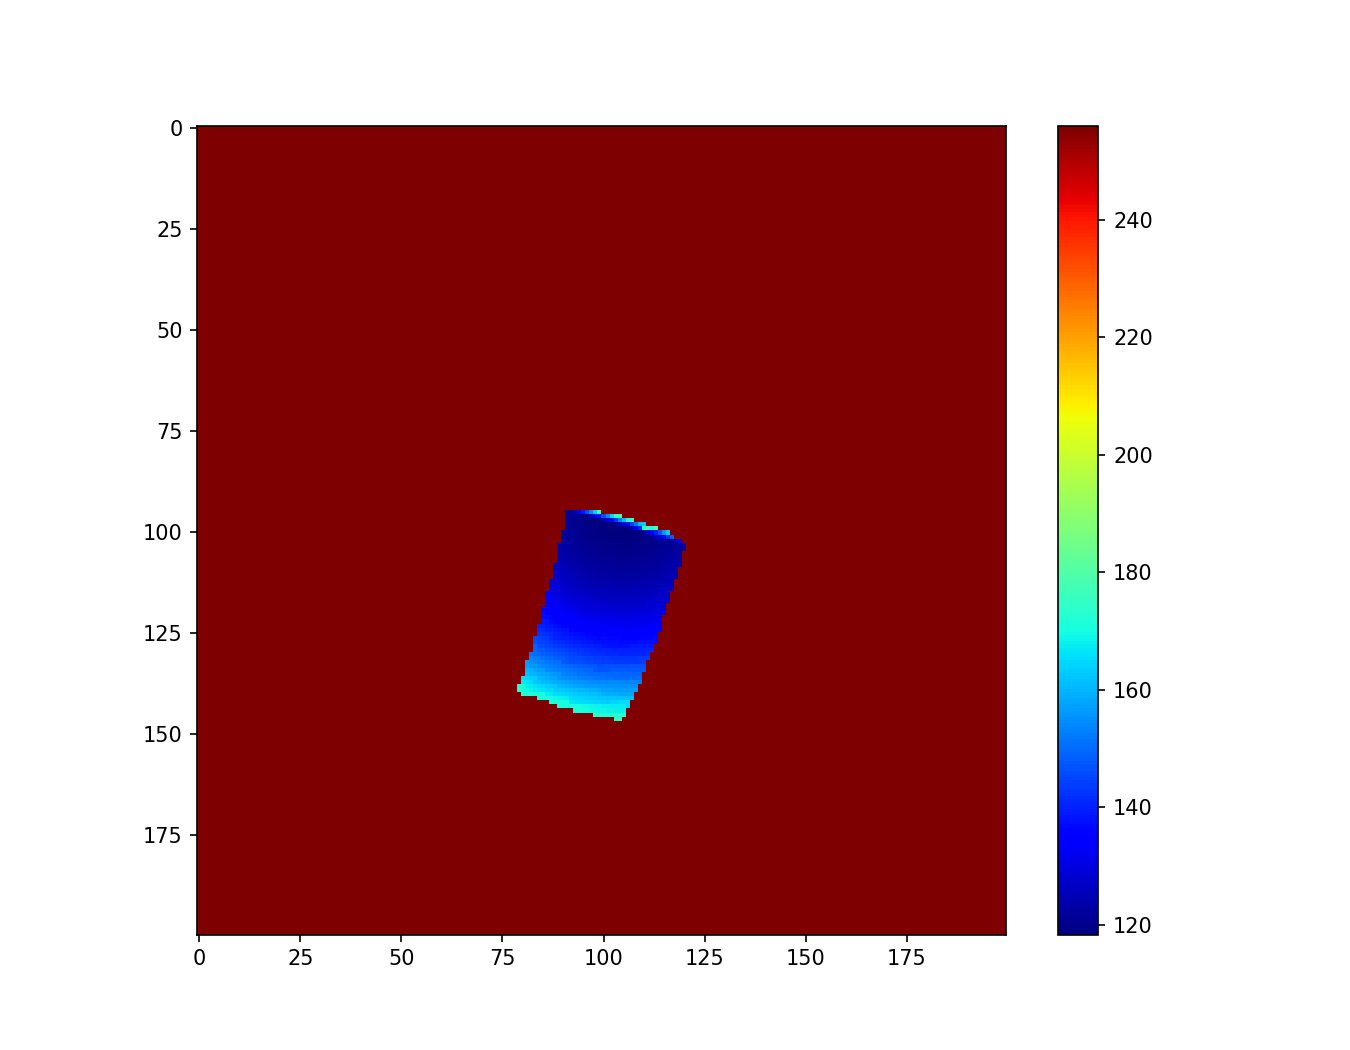

In [237]:
xs = samples[:, 0] - lidar_position[0]
ys = samples[:, 1] - lidar_position[1]
# This is REALLY important, we get the y coordinates in the room, but we want the coordinate from the sensor's
# reference frame.
zs = samples[:, 2] - lidar_position[2]
rs = np.sqrt(np.square(xs) + np.square(ys) + np.square(zs))

omegas = np.arcsin(zs/rs)
alphas = np.arctan2(ys, xs)
# note: zs and ys must be switched in case PLY rooms which are 90deg rotated

# filter_indices = (alphas > 0) & (alphas < np.pi)
# xs = xs[filter_indices]
# ys = ys[filter_indices]
# zs = zs[filter_indices]
# rs = rs[filter_indices]
# omegas = omegas[filter_indices]
# alphas = alphas[filter_indices]

omega_min = -0.5*np.pi # np.min(omegas)
omega_max = 0.5*np.pi # np.max(omegas)
omega_range = omega_max - omega_min

alpha_min = 0 # np.min(alphas)
alpha_max = np.pi # np.max(alphas)
alpha_range = alpha_max - alpha_min

ratio = alpha_range / omega_range
omega_res = 200
alpha_res = int(ratio * omega_res)

max_depth = 5

# Rescale and round to get indices in the image
omega_indices = ((omegas - omega_min) / omega_range) * (omega_res - 1)
omega_indices = np.rint(omega_indices).astype(np.int16)

alpha_indices = ((alphas - alpha_min) / alpha_range) * (alpha_res - 1)
alpha_indices = np.rint(alpha_indices).astype(np.int16)

normalized_r = rs / max_depth

# Initialize image to max distance
canvas = np.ones(shape=(alpha_res, omega_res), dtype=np.float32)
canvas[alpha_indices, omega_indices] = normalized_r

canvas = canvas * 256
canvas = np.flip(canvas, axis=1) # so floor is down
canvas = np.swapaxes(canvas, 0, 1)

plt.figure(0, figsize=(9, 7))
plt.imshow(canvas, cmap="jet")
plt.colorbar()
plt.show()

<IPython.core.display.Javascript object>


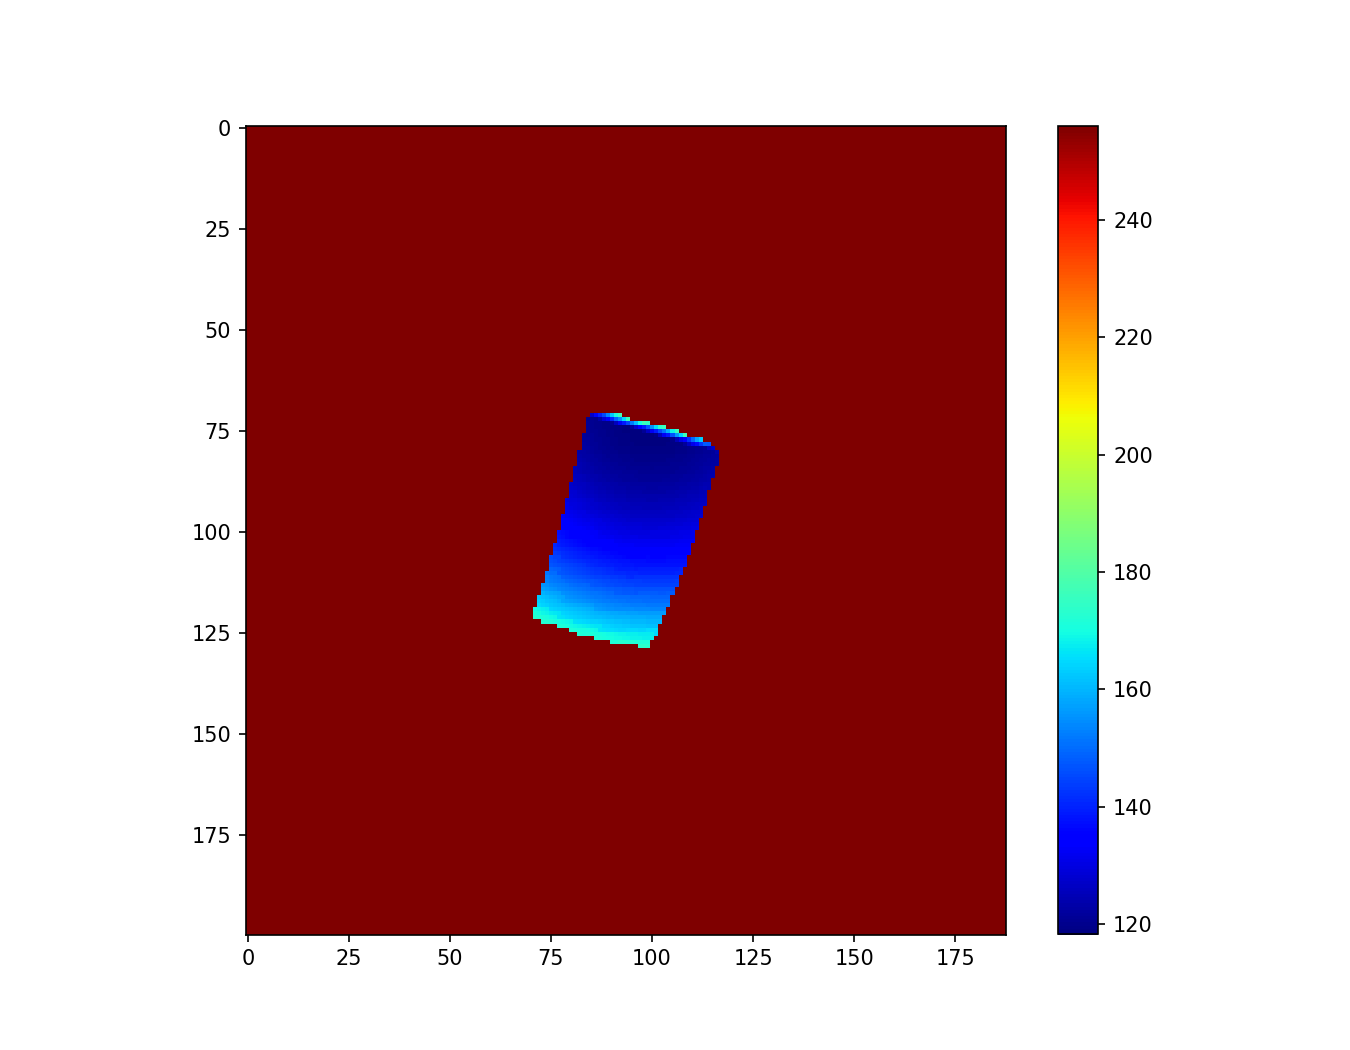

In [272]:
vec = np.zeros((len(xs), 3))
vec[:, 0] = xs
vec[:, 1] = ys
vec[:, 2] = zs
norms = np.linalg.norm(vec, axis=1)
nxs = np.divide(xs, norms)
nys = np.divide(ys, norms)
nzs = np.divide(zs, norms)
#omegas = np.arcsin(nzs)
#alphas = np.arctan2(nys, nxs)
phis = np.arccos(nzs)
thetas = np.arcsin(nxs/np.sin(phis))
# note: zs and ys must be switched in case PLY rooms which are 90deg rotated
omegas = phis
alphas = thetas

#omega_min = -0.5*np.pi # np.min(omegas)
#omega_max = 0.5*np.pi # np.max(omegas)
omega_min = np.min(omegas) - 1
omega_max = np.max(omegas) + 1

omega_range = omega_max - omega_min

alpha_min = np.min(alphas) - 1
alpha_max = np.max(alphas) + 1
alpha_range = alpha_max - alpha_min

ratio = alpha_range / omega_range
omega_res = 200
alpha_res = int(ratio * omega_res)

max_depth = 5

omega_indices = ((omegas - omega_min) / omega_range) * (omega_res - 1)
omega_indices = np.rint(omega_indices).astype(np.int16)

alpha_indices = ((alphas - alpha_min) / alpha_range) * (alpha_res - 1)
alpha_indices = np.rint(alpha_indices).astype(np.int16)

normalized_r = rs / max_depth

canvas = np.ones(shape=(alpha_res, omega_res), dtype=np.float32)
canvas[alpha_indices, omega_indices] = normalized_r

canvas = canvas * 256
canvas = np.flip(canvas, axis=0) # so floor is down
canvas = np.swapaxes(canvas, 0, 1)

plt.figure(9, figsize=(9, 7))
plt.imshow(canvas, cmap="jet")
plt.colorbar()
plt.show()

In [236]:
x_bins = np.arange(-90, 1, 0.2)
y_bins = np.arange(-90, 90, 0.2)
print(np.min(angles[:,0]), np.max(angles[:,0]))
print(np.min(angles[:,1]), np.max(angles[:,1]))
print(np.min(angles[:,2]), np.max(angles[:,2]))
view = np.full((y_bins.size, x_bins.size), -100.0)
x_bin_indices = np.digitize(angles[:,1], x_bins) - 1
y_bin_indices = np.digitize(angles[:,2], y_bins) - 1
for i in range(x_bin_indices.size):
    view[y_bin_indices[i], x_bin_indices[i]] = angles[i, 0]
plt.figure(0, figsize=(8, 8))
plt.imshow(view, cmap="jet")
plt.colorbar()
plt.show()

TypeError: list indices must be integers or slices, not tuple

In [ ]:
A = samples.copy()
y_bins = np.arange(np.min(samples[:, 2]), np.max(samples[:, 2]), 0.1)
x_bins = np.arange(np.min(samples[:, 1]), np.max(samples[:, 1]), 0.1)
view = np.zeros((len(y_bins), len(x_bins) ))
for i in range(900):
    a = A[A[:, 1] == i]
    x_bin_indices = np.digitize(a[:, 2], bins) 
    x = np.zeros((len(bins), 3))
    x[bin_indices] = a[:]
    x[:, 2] = bins
    x[x[:,0] == 0, 0] = 10
    view[:, i] = x[:,0]
plt.figure(1, figsize=(5, 8))
plt.imshow(view, cmap="jet")
plt.show()


In [ ]:
fig = plt.figure(3, figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(xs, ys, zs, marker=",", s=1)
plt.show()